In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime

import spacy
import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.utils import class_weight

#from torchsampler import ImbalancedDatasetSampler

#from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn

from collections import Counter
import re
import string
from random import randint
from random import getrandbits

In [49]:
EPOCHS = 100
BATCH_SIZE = 700
LEARNING_RATE = 0.001

In [3]:
# Read in CSV
df = pd.read_csv("../data/train_80.csv", sep="|")
df_test = pd.read_csv("../data/test_80.csv", sep="|")

In [4]:
# Remove stop words

stop_words = set(stopwords.words('english'))

df['content'] = df.content.str.replace("[^\w\s]","").str.lower()
df['content'] = df['content'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

df_test['content'] = df_test.content.str.replace("[^\w\s]","").str.lower()
df_test['content'] = df_test['content'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

df['title'] = df.title.str.replace("[^\w\s]","").str.lower()
df['title'] = df['title'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

df_test['title'] = df_test.title.str.replace("[^\w\s]","").str.lower()
df_test['title'] = df_test['title'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))


In [5]:
len_list = list()

for index, row in df.iterrows():
    content = row['content']
    length = len(content.split())
    len_list.append(length)
df['content_length'] = len_list
df['content_length'].mean()

436.6719497738947

In [6]:
# label 0 -> gen 5 for each
# label 1 -> skip
# label 2 -> gen 2
# label 3 -> gen 15

def get_syn(word):
    replacements = []
    for syn in wn.synsets(word):
        syn_word = syn.name().split('.')[0]
        if syn_word != word and re.match('\w', word):
            replacements.append(syn_word)
            
    if len(replacements) > 0:
        return replacements[randint(0, len(replacements)-1)]
    else:
        return ''

def random_insertion(sentence, alpha=0.5):
    new_sentence = sentence.copy()
    for i in range(int(len(sentence) * alpha)):
        syn = get_syn(sentence[randint(0, len(sentence) - 1)])
        if syn:
            new_sentence.insert(randint(0, len(new_sentence)), syn)
    return new_sentence

def random_replacement(sentence, alpha=0.5):
    new_sentence = sentence.copy()
    for i in range(int(len(sentence) * alpha)):
        word_id = randint(0, len(sentence) - 1)
        syn = get_syn(sentence[word_id])
        if syn:
            new_sentence[word_id] = syn
    return new_sentence

def augment(dataframe):
    df = dataframe   
    df = df[["title", "content", "label_log_10"]]
    new_sentences_df = pd.DataFrame(columns=['title','content','label_log_10'])
    for index, row in df.iterrows():
        if row["label_log_10"] is 0:
            for i in range (10):
                tmp = " "
                tmp_title = " "
                str_list = list(row["content"].split(" "))
                title_list = list(row["title"].split(" "))
                if bool(getrandbits(1)) is True:
                    new_sentence = random_insertion(str_list)
                    new_title = random_insertion(title_list)
                else:
                    new_sentence = random_replacement(str_list)
                    new_title = random_replacement(title_list)
                new_sentence = tmp.join(new_sentence)
                new_title = tmp_title.join(new_title)
                new_sentences_df = new_sentences_df.append(pd.DataFrame([[new_title, new_sentence, row["label_log_10"]]], columns=['title','content','label_log_10']))
            continue
        if row["label_log_10"] is 2:
            for j in range (2):
                tmp = " "
                tmp_title = " "
                str_list = list(row["content"].split(" "))
                title_list = list(row["title"].split(" "))
                if bool(getrandbits(1)) is True:
                    new_sentence = random_insertion(str_list)
                    new_title = random_insertion(title_list)
                else:
                    new_sentence = random_replacement(str_list)
                    new_title = random_replacement(title_list)
                new_sentence = tmp.join(new_sentence)
                new_title = tmp_title.join(new_title)
                new_sentences_df = new_sentences_df.append(pd.DataFrame([[new_title, new_sentence, row["label_log_10"]]], columns=['title','content','label_log_10']))
            continue
        if row["label_log_10"] is 3:
            for k in range (30):
                tmp = " "
                tmp_title = " "
                str_list = list(row["content"].split(" "))
                title_list = list(row["title"].split(" "))
                if bool(getrandbits(1)) is True:
                    new_sentence = random_insertion(str_list)
                    new_title = random_insertion(title_list)
                else:
                    new_sentence = random_replacement(str_list)
                    new_title = random_replacement(title_list)
                new_sentence = tmp.join(new_sentence)
                new_title = tmp_title.join(new_title)
                new_sentences_df = new_sentences_df.append(pd.DataFrame([[new_title, new_sentence, row["label_log_10"]]], columns=['title','content','label_log_10']))
            continue

    df = df.append(new_sentences_df)
    return df

df = augment(df)
df_test = augment(df_test)

In [10]:
# combine title and text, delete other columns
df["full_text"] = df['title'] + ' ' + df["content"]
#df["full_text"] =  df["content"]
df = df[["full_text", "label_log_10"]]

df_test["full_text"] = df_test['title'] + ' ' + df_test["content"] 
df_test = df_test[["full_text", "label_log_10"]]

In [11]:
train = df
test = df_test

In [12]:
def balance_classes(dataframe):
    train = dataframe
    count_dict = {
        "0":0,
        "1":0,
        "2":0,
        "3":0
    }

    for index, row in train.iterrows():
        if row['label_log_10'] == 0.0:
            count_dict["0"] += 1
        elif row['label_log_10'] == 1.0:
            count_dict["1"] += 1
        elif row['label_log_10'] == 2.0:
            count_dict["2"] += 1
        else:
            count_dict["3"] += 1

    print(count_dict)

    train_0 = train[train.label_log_10 == 0]
    train_1 = train[train.label_log_10 == 1]
    train_2 = train[train.label_log_10 == 2]
    train_3 = train[train.label_log_10 == 3]

    train = train_0.sample(n=count_dict["3"])
    train = train.append(train_1.sample(n=count_dict["3"]))
    train = train.append(train_2.sample(n=count_dict["3"]))
    train = train.append(train_3.sample(n=count_dict["3"]))
    train = train.sample(frac=1)
    #print(train.shape)
    return train

train = balance_classes(train)
test = balance_classes(test)

{'0': 15862, '1': 15104, '2': 17316, '3': 14229}
{'0': 3883, '1': 3809, '2': 4275, '3': 3317}


## Word Tokenizer

In [13]:
#tokenization
tok = spacy.load('en')
def tokenize(text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [14]:
#count number of occurences of each word in train set
counts = Counter()
for index, row in train.iterrows():
    counts.update(tokenize(row['full_text']))

In [15]:
#deleting infrequnet words
print("num_words before:", len(counts.keys()))
#for word in list(counts):
#    if counts[word] < 2:
#        del counts[word]
#print("num_words after:",len(counts.keys()))

num_words before: 121048


In [16]:
# creating vocab
vocab2index = {"":0, "UNK":1}
words = ["","UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [38]:
def encode_sentence(text, vocab2index, N=450):
    tokenized = tokenize(text)
    encoded = np.zeros(N,dtype=int)
    enc1 = np.array([vocab2index.get(word,vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

## GloVe Embeddings

In [18]:
def load_glove_vectors(glove_file="../data/glove.6B.100d.txt"):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file, encoding="utf8") as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [19]:
def get_emb_matrix(pretrained, word_counts, emb_size = 100):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    vocab_to_idx[""] = 0
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [20]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [39]:
train['encoded'] = train['full_text'].apply(lambda x: np.array(encode_sentence(x,vocab2index)))
test['encoded'] = test['full_text'].apply(lambda x: np.array(encode_sentence(x,vocab2index)))

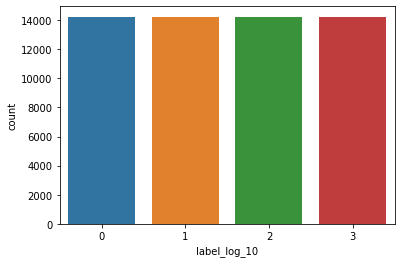

In [22]:
sns.countplot(x = 'label_log_10', data=train)

In [40]:
X_train, y_train = list(train['encoded']), list(train['label_log_10'])
X_valid, y_valid = list(test['encoded']), list(test['label_log_10'])

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [42]:
class NewsDataset(Dataset):
    def __init__(self, X, Y):
            self.X = X
            self.y = Y
            
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)).to(device), self.y[idx], self.X[idx][1]

In [43]:
train_ds = NewsDataset(X_train, y_train)
valid_ds = NewsDataset(X_valid, y_valid)

## MY own sampler

In [25]:
class_0 = train[train.label_log_10 == 0].shape[0]
class_1 = train[train.label_log_10 == 1].shape[0]
class_2 = train[train.label_log_10 == 2].shape[0]
class_3 = train[train.label_log_10 == 3].shape[0]
total = class_0 + class_1 + class_2 + class_3
weights = torch.FloatTensor([1/class_0/2, 1/class_1, 1/class_2, 2.5*(1/class_3)])  * class_1
print(weights)

weighted_sampler = WeightedRandomSampler(
    weights = weights, 
    num_samples = len(weights),
    replacement = True
)

tensor([ 5.1833,  1.0000,  2.6189, 81.3239])


## Sklearn class_weight

In [25]:
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

## Weighted Random Sampler

In [21]:
def get_class_distribution(obj):
    count_dict = {
        "0":0,
        "1":0,
        "2":0,
        "3":0
    }
    
    for i in obj:
        if i == 0.0:
            count_dict["0"] += 1
        elif i == 1.0:
            count_dict["1"] += 1
        elif i == 2.0:
            count_dict["2"] += 1
        else:
            count_dict["3"] += 1
    return count_dict

In [22]:
target_list = []

for _, t, s in train_ds:
    target_list.append(t)

target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [23]:
class_count = [i for i in get_class_distribution(train['label_log_10']).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)

print(class_weights)

tensor([7.8493e-04, 7.5717e-05, 1.9829e-04, 2.4631e-03])


In [24]:
class_weights_all = class_weights[target_list]

weighted_sampler = WeightedRandomSampler(
    weights = class_weights_all, 
    num_samples = len(class_weights_all),
    replacement = True
)

In [44]:
def train_model(model):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
    #criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    for i in range(EPOCHS):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().to(device)
            y = y.long().to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            #loss = criterion(y_pred, y)
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() *y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse, y_pred_list = validation_metrics(model, val_dl)
        if i%5 == 0:
            print("EPOCH ", i, ": train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))
            print(classification_report(y_valid, y_pred_list))
def validation_metrics (model, valid_dl):
    #criterion = nn.CrossEntropyLoss(weight=weights)
    y_pred_list = list()
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long().to(device)
        y = y.long()
        y_hat = model(x, l).cpu()
        #loss = criterion(y_hat, y)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        for i in pred:
            tmp = int(i.numpy())
            y_pred_list.append(tmp)
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total, y_pred_list

In [50]:
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [46]:
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2)
        self.linear = nn.Linear(2*hidden_dim, 4)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(torch.cat((ht[-2], ht[-1]), dim=1))

In [26]:
class LSTM_variable_len(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 4)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [51]:
model = LSTM_glove_vecs(vocab_size, 100, 50, pretrained_weights)
#model = LSTM_variable_len(vocab_size, 50, 50)

## Full content no punc [log10 distribution]

In [44]:
train_model(model.to(device))

train loss 1.382, val loss 1.383, val accuracy 0.399, and val rmse 1.195
              precision    recall  f1-score   support

           0       0.11      0.04      0.06       521
           1       0.71      0.51      0.59      5706
           2       0.26      0.19      0.22      2154
           3       0.03      0.44      0.05       160

    accuracy                           0.40      8541
   macro avg       0.28      0.29      0.23      8541
weighted avg       0.55      0.40      0.46      8541

train loss 1.357, val loss 1.440, val accuracy 0.340, and val rmse 1.396
              precision    recall  f1-score   support

           0       0.12      0.03      0.05       521
           1       0.71      0.48      0.57      5706
           2       0.26      0.01      0.02      2154
           3       0.03      0.69      0.05       160

    accuracy                           0.34      8541
   macro avg       0.28      0.31      0.18      8541
weighted avg       0.55      0.34      

train loss 1.114, val loss 1.302, val accuracy 0.253, and val rmse 1.060
              precision    recall  f1-score   support

           0       0.14      0.59      0.23       521
           1       0.73      0.05      0.10      5706
           2       0.30      0.71      0.42      2154
           3       0.03      0.18      0.06       160

    accuracy                           0.25      8541
   macro avg       0.30      0.38      0.20      8541
weighted avg       0.57      0.25      0.19      8541

train loss 1.113, val loss 1.273, val accuracy 0.273, and val rmse 1.045
              precision    recall  f1-score   support

           0       0.16      0.51      0.25       521
           1       0.72      0.08      0.14      5706
           2       0.29      0.74      0.42      2154
           3       0.03      0.17      0.05       160

    accuracy                           0.27      8541
   macro avg       0.30      0.38      0.22      8541
weighted avg       0.57      0.27      

train loss 1.026, val loss 1.287, val accuracy 0.276, and val rmse 1.051
              precision    recall  f1-score   support

           0       0.13      0.64      0.22       521
           1       0.71      0.11      0.20      5706
           2       0.32      0.62      0.42      2154
           3       0.04      0.23      0.07       160

    accuracy                           0.28      8541
   macro avg       0.30      0.40      0.23      8541
weighted avg       0.56      0.28      0.25      8541

train loss 1.025, val loss 1.296, val accuracy 0.278, and val rmse 1.043
              precision    recall  f1-score   support

           0       0.14      0.64      0.23       521
           1       0.72      0.12      0.20      5706
           2       0.31      0.62      0.42      2154
           3       0.04      0.22      0.07       160

    accuracy                           0.28      8541
   macro avg       0.30      0.40      0.23      8541
weighted avg       0.57      0.28      

train loss 1.041, val loss 1.333, val accuracy 0.185, and val rmse 1.493
              precision    recall  f1-score   support

           0       0.15      0.32      0.21       521
           1       0.69      0.12      0.21      5706
           2       0.33      0.29      0.31      2154
           3       0.02      0.48      0.03       160

    accuracy                           0.18      8541
   macro avg       0.30      0.30      0.19      8541
weighted avg       0.56      0.18      0.23      8541

train loss 1.037, val loss 1.266, val accuracy 0.509, and val rmse 0.869
              precision    recall  f1-score   support

           0       0.15      0.36      0.21       521
           1       0.70      0.62      0.66      5706
           2       0.35      0.27      0.30      2154
           3       0.05      0.17      0.08       160

    accuracy                           0.51      8541
   macro avg       0.31      0.36      0.31      8541
weighted avg       0.57      0.51      

train loss 0.934, val loss 1.247, val accuracy 0.309, and val rmse 0.983
              precision    recall  f1-score   support

           0       0.16      0.51      0.25       521
           1       0.71      0.15      0.24      5706
           2       0.29      0.70      0.41      2154
           3       0.05      0.16      0.07       160

    accuracy                           0.31      8541
   macro avg       0.30      0.38      0.24      8541
weighted avg       0.56      0.31      0.28      8541

train loss 0.943, val loss 1.246, val accuracy 0.317, and val rmse 0.978
              precision    recall  f1-score   support

           0       0.17      0.47      0.25       521
           1       0.70      0.16      0.26      5706
           2       0.29      0.70      0.41      2154
           3       0.04      0.16      0.07       160

    accuracy                           0.32      8541
   macro avg       0.30      0.37      0.25      8541
weighted avg       0.55      0.32      

## LSTM, hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train only), N=800, weighted random sampler, (batch_size=128)

In [37]:
train_model(model.to(device))

train loss 1.357, val loss 1.436, val accuracy 0.041, and val rmse 1.780
              precision    recall  f1-score   support

           0       0.12      0.19      0.15       521
           1       0.60      0.01      0.02      5706
           2       0.26      0.02      0.04      2154
           3       0.02      0.86      0.04       160

    accuracy                           0.04      8541
   macro avg       0.25      0.27      0.06      8541
weighted avg       0.47      0.04      0.04      8541

train loss 1.292, val loss 1.377, val accuracy 0.241, and val rmse 1.039
              precision    recall  f1-score   support

           0       0.15      0.28      0.19       521
           1       0.65      0.03      0.06      5706
           2       0.25      0.80      0.39      2154
           3       0.03      0.09      0.04       160

    accuracy                           0.24      8541
   macro avg       0.27      0.30      0.17      8541
weighted avg       0.51      0.24      

train loss 1.118, val loss 1.450, val accuracy 0.292, and val rmse 1.013
              precision    recall  f1-score   support

           0       0.12      0.31      0.17       521
           1       0.63      0.18      0.28      5706
           2       0.26      0.61      0.36      2154
           3       0.03      0.09      0.04       160

    accuracy                           0.29      8541
   macro avg       0.26      0.30      0.21      8541
weighted avg       0.49      0.29      0.29      8541

train loss 1.120, val loss 1.480, val accuracy 0.296, and val rmse 1.014
              precision    recall  f1-score   support

           0       0.19      0.21      0.20       521
           1       0.63      0.16      0.25      5706
           2       0.26      0.70      0.38      2154
           3       0.03      0.11      0.04       160

    accuracy                           0.30      8541
   macro avg       0.28      0.30      0.22      8541
weighted avg       0.50      0.30      

train loss 1.147, val loss 1.423, val accuracy 0.592, and val rmse 0.741
              precision    recall  f1-score   support

           0       0.16      0.10      0.13       521
           1       0.68      0.81      0.74      5706
           2       0.31      0.18      0.23      2154
           3       0.05      0.07      0.06       160

    accuracy                           0.59      8541
   macro avg       0.30      0.29      0.29      8541
weighted avg       0.55      0.59      0.56      8541

train loss 1.183, val loss 1.489, val accuracy 0.563, and val rmse 0.784
              precision    recall  f1-score   support

           0       0.23      0.08      0.12       521
           1       0.68      0.75      0.71      5706
           2       0.29      0.23      0.25      2154
           3       0.02      0.04      0.03       160

    accuracy                           0.56      8541
   macro avg       0.30      0.28      0.28      8541
weighted avg       0.54      0.56      

## LSTM, hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=800, weighted random sampler, (batch_size=128)

In [31]:
train_model(model.to(device))

EPOCH  1 : train loss 1.364, val loss 1.357, val accuracy 0.621, and val rmse 0.707
              precision    recall  f1-score   support

           0       0.12      0.15      0.13       521
           1       0.68      0.90      0.77      5706
           2       0.36      0.05      0.09      2154
           3       0.00      0.00      0.00       160

    accuracy                           0.62      8541
   macro avg       0.29      0.27      0.25      8541
weighted avg       0.55      0.62      0.55      8541

EPOCH  6 : train loss 1.299, val loss 1.314, val accuracy 0.634, and val rmse 0.681
              precision    recall  f1-score   support

           0       0.16      0.12      0.14       521
           1       0.68      0.92      0.78      5706
           2       0.36      0.06      0.10      2154
           3       0.04      0.02      0.02       160

    accuracy                           0.63      8541
   macro avg       0.31      0.28      0.26      8541
weighted avg     

EPOCH  81 : train loss 1.238, val loss 1.353, val accuracy 0.652, and val rmse 0.655
              precision    recall  f1-score   support

           0       0.24      0.07      0.11       521
           1       0.68      0.94      0.79      5706
           2       0.41      0.06      0.11      2154
           3       0.06      0.04      0.05       160

    accuracy                           0.65      8541
   macro avg       0.35      0.28      0.27      8541
weighted avg       0.57      0.65      0.56      8541

EPOCH  86 : train loss 1.233, val loss 1.356, val accuracy 0.653, and val rmse 0.651
              precision    recall  f1-score   support

           0       0.29      0.06      0.10       521
           1       0.68      0.94      0.79      5706
           2       0.39      0.07      0.13      2154
           3       0.05      0.03      0.04       160

    accuracy                           0.65      8541
   macro avg       0.35      0.28      0.26      8541
weighted avg   

## BiLSTM (num_layers=1), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=800, own sampler, (batch_size=128)

In [129]:
train_model(model.to(device))

EPOCH  0 : train loss 1.307, val loss 1.216, val accuracy 0.408, and val rmse 1.112
              precision    recall  f1-score   support

           0       0.21      0.31      0.25       521
           1       0.79      0.42      0.54      5706
           2       0.36      0.41      0.38      2154
           3       0.03      0.46      0.06       160

    accuracy                           0.41      8541
   macro avg       0.35      0.40      0.31      8541
weighted avg       0.63      0.41      0.48      8541

EPOCH  5 : train loss 1.128, val loss 1.098, val accuracy 0.465, and val rmse 1.025
              precision    recall  f1-score   support

           0       0.25      0.31      0.27       521
           1       0.80      0.50      0.62      5706
           2       0.38      0.40      0.39      2154
           3       0.04      0.50      0.07       160

    accuracy                           0.47      8541
   macro avg       0.37      0.43      0.34      8541
weighted avg     

EPOCH  80 : train loss 0.623, val loss 1.049, val accuracy 0.529, and val rmse 0.803
              precision    recall  f1-score   support

           0       0.30      0.49      0.37       521
           1       0.83      0.50      0.62      5706
           2       0.39      0.64      0.49      2154
           3       0.06      0.28      0.10       160

    accuracy                           0.53      8541
   macro avg       0.40      0.48      0.40      8541
weighted avg       0.67      0.53      0.56      8541

EPOCH  85 : train loss 0.612, val loss 0.974, val accuracy 0.561, and val rmse 0.745
              precision    recall  f1-score   support

           0       0.27      0.53      0.36       521
           1       0.82      0.54      0.65      5706
           2       0.42      0.65      0.51      2154
           3       0.07      0.19      0.11       160

    accuracy                           0.56      8541
   macro avg       0.40      0.48      0.41      8541
weighted avg   

## BiLSTM (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=800, own sampler (batch_size=128)

In [132]:
train_model(model.to(device))

EPOCH  0 : train loss 1.278, val loss 1.134, val accuracy 0.418, and val rmse 1.167
              precision    recall  f1-score   support

           0       0.19      0.32      0.24       521
           1       0.77      0.52      0.62      5706
           2       0.45      0.15      0.22      2154
           3       0.03      0.66      0.06       160

    accuracy                           0.42      8541
   macro avg       0.36      0.41      0.29      8541
weighted avg       0.64      0.42      0.49      8541

EPOCH  5 : train loss 1.069, val loss 1.096, val accuracy 0.451, and val rmse 1.046
              precision    recall  f1-score   support

           0       0.23      0.46      0.30       521
           1       0.81      0.47      0.59      5706
           2       0.41      0.39      0.40      2154
           3       0.04      0.51      0.07       160

    accuracy                           0.45      8541
   macro avg       0.37      0.46      0.34      8541
weighted avg     

EPOCH  80 : train loss 0.483, val loss 0.977, val accuracy 0.597, and val rmse 0.709
              precision    recall  f1-score   support

           0       0.31      0.53      0.39       521
           1       0.80      0.62      0.70      5706
           2       0.45      0.59      0.51      2154
           3       0.07      0.18      0.10       160

    accuracy                           0.60      8541
   macro avg       0.41      0.48      0.42      8541
weighted avg       0.67      0.60      0.62      8541

EPOCH  85 : train loss 0.475, val loss 0.980, val accuracy 0.597, and val rmse 0.705
              precision    recall  f1-score   support

           0       0.32      0.52      0.39       521
           1       0.81      0.60      0.69      5706
           2       0.45      0.63      0.52      2154
           3       0.07      0.19      0.11       160

    accuracy                           0.60      8541
   macro avg       0.41      0.49      0.43      8541
weighted avg   

## BiLSTM (num_layers=3), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=800, own sampler (batch_size=128)

In [135]:
train_model(model.to(device))

EPOCH  0 : train loss 1.280, val loss 1.283, val accuracy 0.409, and val rmse 0.915
              precision    recall  f1-score   support

           0       0.17      0.42      0.24       521
           1       0.82      0.29      0.43      5706
           2       0.34      0.75      0.47      2154
           3       0.02      0.06      0.03       160

    accuracy                           0.41      8541
   macro avg       0.34      0.38      0.29      8541
weighted avg       0.65      0.41      0.42      8541

EPOCH  5 : train loss 1.089, val loss 1.117, val accuracy 0.455, and val rmse 1.047
              precision    recall  f1-score   support

           0       0.25      0.33      0.29       521
           1       0.80      0.48      0.60      5706
           2       0.40      0.40      0.40      2154
           3       0.04      0.51      0.07       160

    accuracy                           0.45      8541
   macro avg       0.37      0.43      0.34      8541
weighted avg     

EPOCH  80 : train loss 0.451, val loss 1.010, val accuracy 0.579, and val rmse 0.732
              precision    recall  f1-score   support

           0       0.32      0.52      0.40       521
           1       0.84      0.57      0.68      5706
           2       0.43      0.65      0.51      2154
           3       0.06      0.22      0.10       160

    accuracy                           0.58      8541
   macro avg       0.41      0.49      0.42      8541
weighted avg       0.69      0.58      0.61      8541

EPOCH  85 : train loss 0.442, val loss 0.946, val accuracy 0.626, and val rmse 0.670
              precision    recall  f1-score   support

           0       0.34      0.48      0.39       521
           1       0.82      0.65      0.73      5706
           2       0.47      0.62      0.53      2154
           3       0.08      0.19      0.11       160

    accuracy                           0.63      8541
   macro avg       0.43      0.49      0.44      8541
weighted avg   

## BiLSTM (content+text) (num_layers=1), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=1000, own sampler 1.2*(1/class_3) (batch_size=128)

In [26]:
train_model(model.to(device))

EPOCH  0 : train loss 1.306, val loss 1.208, val accuracy 0.470, and val rmse 0.869
              precision    recall  f1-score   support

           0       0.21      0.25      0.23       521
           1       0.76      0.45      0.56      5706
           2       0.33      0.60      0.42      2154
           3       0.05      0.18      0.07       160

    accuracy                           0.47      8541
   macro avg       0.34      0.37      0.32      8541
weighted avg       0.60      0.47      0.50      8541

EPOCH  5 : train loss 1.117, val loss 1.220, val accuracy 0.377, and val rmse 1.104
              precision    recall  f1-score   support

           0       0.26      0.39      0.31       521
           1       0.82      0.36      0.50      5706
           2       0.31      0.41      0.35      2154
           3       0.04      0.57      0.07       160

    accuracy                           0.38      8541
   macro avg       0.36      0.43      0.31      8541
weighted avg     

EPOCH  80 : train loss 0.598, val loss 1.068, val accuracy 0.539, and val rmse 0.794
              precision    recall  f1-score   support

           0       0.28      0.56      0.37       521
           1       0.83      0.53      0.65      5706
           2       0.41      0.57      0.48      2154
           3       0.07      0.36      0.11       160

    accuracy                           0.54      8541
   macro avg       0.40      0.50      0.40      8541
weighted avg       0.67      0.54      0.58      8541

EPOCH  85 : train loss 0.580, val loss 1.001, val accuracy 0.553, and val rmse 0.750
              precision    recall  f1-score   support

           0       0.27      0.56      0.37       521
           1       0.82      0.53      0.64      5706
           2       0.42      0.63      0.50      2154
           3       0.08      0.25      0.12       160

    accuracy                           0.55      8541
   macro avg       0.40      0.49      0.41      8541
weighted avg   

## BiLSTM (content+text) (num_layers=1), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=1000, own sampler 1.5*(1/class_3) (batch_size=128)

In [32]:
train_model(model.to(device))

EPOCH  0 : train loss 1.291, val loss 1.337, val accuracy 0.202, and val rmse 1.554
              precision    recall  f1-score   support

           0       0.19      0.16      0.17       521
           1       0.79      0.25      0.38      5706
           2       0.32      0.03      0.05      2154
           3       0.02      0.89      0.05       160

    accuracy                           0.20      8541
   macro avg       0.33      0.33      0.16      8541
weighted avg       0.62      0.20      0.28      8541

EPOCH  5 : train loss 1.129, val loss 1.247, val accuracy 0.333, and val rmse 1.259
              precision    recall  f1-score   support

           0       0.19      0.39      0.26       521
           1       0.80      0.39      0.52      5706
           2       0.31      0.14      0.19      2154
           3       0.03      0.76      0.06       160

    accuracy                           0.33      8541
   macro avg       0.33      0.42      0.26      8541
weighted avg     

EPOCH  80 : train loss 0.569, val loss 1.016, val accuracy 0.544, and val rmse 0.768
              precision    recall  f1-score   support

           0       0.28      0.53      0.37       521
           1       0.82      0.52      0.64      5706
           2       0.41      0.64      0.50      2154
           3       0.06      0.24      0.10       160

    accuracy                           0.54      8541
   macro avg       0.39      0.48      0.40      8541
weighted avg       0.67      0.54      0.57      8541

EPOCH  85 : train loss 0.580, val loss 1.015, val accuracy 0.541, and val rmse 0.759
              precision    recall  f1-score   support

           0       0.27      0.54      0.36       521
           1       0.83      0.51      0.63      5706
           2       0.40      0.66      0.50      2154
           3       0.07      0.23      0.11       160

    accuracy                           0.54      8541
   macro avg       0.39      0.48      0.40      8541
weighted avg   

## BiLSTM (content+text) (num_layers=1), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=1000, own sampler 1.3*(1/class_3) (batch_size=256)

In [25]:
train_model(model.to(device))

EPOCH  0 : train loss 1.317, val loss 1.358, val accuracy 0.240, and val rmse 1.525
              precision    recall  f1-score   support

           0       0.25      0.02      0.03       521
           1       0.77      0.33      0.46      5706
           2       0.27      0.02      0.03      2154
           3       0.02      0.91      0.05       160

    accuracy                           0.24      8541
   macro avg       0.33      0.32      0.14      8541
weighted avg       0.60      0.24      0.32      8541

EPOCH  5 : train loss 1.140, val loss 1.303, val accuracy 0.277, and val rmse 1.291
              precision    recall  f1-score   support

           0       0.20      0.44      0.28       521
           1       0.81      0.26      0.39      5706
           2       0.29      0.26      0.27      2154
           3       0.03      0.69      0.06       160

    accuracy                           0.28      8541
   macro avg       0.33      0.41      0.25      8541
weighted avg     

EPOCH  80 : train loss 0.607, val loss 1.052, val accuracy 0.525, and val rmse 0.795
              precision    recall  f1-score   support

           0       0.26      0.60      0.36       521
           1       0.82      0.50      0.62      5706
           2       0.40      0.60      0.48      2154
           3       0.07      0.31      0.11       160

    accuracy                           0.52      8541
   macro avg       0.39      0.50      0.39      8541
weighted avg       0.67      0.52      0.56      8541

EPOCH  85 : train loss 0.581, val loss 0.997, val accuracy 0.545, and val rmse 0.759
              precision    recall  f1-score   support

           0       0.30      0.48      0.37       521
           1       0.83      0.50      0.63      5706
           2       0.40      0.69      0.51      2154
           3       0.09      0.27      0.13       160

    accuracy                           0.54      8541
   macro avg       0.40      0.49      0.41      8541
weighted avg   

## BiLSTM (content+text) (num_layers=1), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=1500, own sampler (1/class_3) (batch_size=512)

In [26]:
train_model(model.to(device))

EPOCH  0 : train loss 1.345, val loss 1.311, val accuracy 0.245, and val rmse 1.515
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       521
           1       0.76      0.32      0.46      5706
           2       0.26      0.05      0.08      2154
           3       0.02      0.84      0.05       160

    accuracy                           0.25      8541
   macro avg       0.26      0.30      0.15      8541
weighted avg       0.57      0.25      0.33      8541



E:\Programs\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


EPOCH  5 : train loss 1.167, val loss 1.229, val accuracy 0.327, and val rmse 1.170
              precision    recall  f1-score   support

           0       0.17      0.48      0.25       521
           1       0.79      0.31      0.44      5706
           2       0.32      0.33      0.32      2154
           3       0.03      0.56      0.06       160

    accuracy                           0.33      8541
   macro avg       0.33      0.42      0.27      8541
weighted avg       0.62      0.33      0.39      8541

EPOCH  10 : train loss 1.110, val loss 1.208, val accuracy 0.353, and val rmse 1.122
              precision    recall  f1-score   support

           0       0.22      0.43      0.29       521
           1       0.82      0.34      0.48      5706
           2       0.29      0.36      0.32      2154
           3       0.04      0.57      0.07       160

    accuracy                           0.35      8541
   macro avg       0.34      0.43      0.29      8541
weighted avg    

EPOCH  85 : train loss 0.666, val loss 1.025, val accuracy 0.528, and val rmse 0.793
              precision    recall  f1-score   support

           0       0.26      0.59      0.36       521
           1       0.81      0.51      0.62      5706
           2       0.40      0.59      0.48      2154
           3       0.08      0.31      0.12       160

    accuracy                           0.53      8541
   macro avg       0.39      0.50      0.40      8541
weighted avg       0.66      0.53      0.56      8541

EPOCH  90 : train loss 0.654, val loss 1.080, val accuracy 0.494, and val rmse 0.826
              precision    recall  f1-score   support

           0       0.25      0.60      0.35       521
           1       0.83      0.43      0.57      5706
           2       0.39      0.65      0.48      2154
           3       0.07      0.31      0.11       160

    accuracy                           0.49      8541
   macro avg       0.38      0.50      0.38      8541
weighted avg   

## BiLSTM (content+text) (num_layers=1), hidden_dim=100 GloVe embeddings emb_size=100, no stop words (train + test), N=800, own sampler (1/class_3) (batch_size=512)

In [28]:
train_model(model.to(device))

EPOCH  0 : train loss 1.321, val loss 1.257, val accuracy 0.490, and val rmse 0.822
              precision    recall  f1-score   support

           0       0.25      0.05      0.08       521
           1       0.75      0.48      0.59      5706
           2       0.32      0.65      0.43      2154
           3       0.05      0.12      0.07       160

    accuracy                           0.49      8541
   macro avg       0.34      0.32      0.29      8541
weighted avg       0.59      0.49      0.50      8541

EPOCH  5 : train loss 1.106, val loss 1.140, val accuracy 0.418, and val rmse 1.061
              precision    recall  f1-score   support

           0       0.21      0.46      0.28       521
           1       0.80      0.46      0.58      5706
           2       0.34      0.30      0.32      2154
           3       0.04      0.54      0.07       160

    accuracy                           0.42      8541
   macro avg       0.35      0.44      0.31      8541
weighted avg     

EPOCH  80 : train loss 0.419, val loss 0.978, val accuracy 0.632, and val rmse 0.668
              precision    recall  f1-score   support

           0       0.34      0.50      0.41       521
           1       0.81      0.66      0.73      5706
           2       0.48      0.61      0.54      2154
           3       0.08      0.16      0.11       160

    accuracy                           0.63      8541
   macro avg       0.43      0.49      0.44      8541
weighted avg       0.68      0.63      0.65      8541

EPOCH  85 : train loss 0.404, val loss 1.027, val accuracy 0.609, and val rmse 0.695
              precision    recall  f1-score   support

           0       0.34      0.47      0.40       521
           1       0.82      0.62      0.71      5706
           2       0.45      0.64      0.53      2154
           3       0.07      0.21      0.11       160

    accuracy                           0.61      8541
   macro avg       0.42      0.49      0.44      8541
weighted avg   

## BiLSTM (content+title) (num_layers=1), hidden_dim=75 GloVe embeddings emb_size=200, no stop words (train + test), N=600, own sampler  1.5 *(1/class_3) (batch_size=64)

In [30]:
train_model(model.to(device))

EPOCH  0 : train loss 1.226, val loss 1.182, val accuracy 0.253, and val rmse 1.416
              precision    recall  f1-score   support

           0       0.18      0.40      0.25       521
           1       0.77      0.31      0.45      5706
           2       0.42      0.01      0.01      2154
           3       0.03      0.88      0.05       160

    accuracy                           0.25      8541
   macro avg       0.35      0.40      0.19      8541
weighted avg       0.63      0.25      0.32      8541

EPOCH  5 : train loss 0.876, val loss 1.232, val accuracy 0.474, and val rmse 0.955
              precision    recall  f1-score   support

           0       0.25      0.49      0.33       521
           1       0.80      0.51      0.62      5706
           2       0.38      0.37      0.37      2154
           3       0.05      0.50      0.08       160

    accuracy                           0.47      8541
   macro avg       0.37      0.47      0.35      8541
weighted avg     

EPOCH  80 : train loss 0.252, val loss 3.432, val accuracy 0.638, and val rmse 0.652
              precision    recall  f1-score   support

           0       0.34      0.45      0.39       521
           1       0.81      0.67      0.74      5706
           2       0.49      0.63      0.55      2154
           3       0.06      0.12      0.08       160

    accuracy                           0.64      8541
   macro avg       0.42      0.47      0.44      8541
weighted avg       0.69      0.64      0.65      8541

EPOCH  85 : train loss 0.254, val loss 3.294, val accuracy 0.643, and val rmse 0.654
              precision    recall  f1-score   support

           0       0.36      0.43      0.39       521
           1       0.81      0.69      0.74      5706
           2       0.49      0.61      0.54      2154
           3       0.07      0.16      0.10       160

    accuracy                           0.64      8541
   macro avg       0.43      0.47      0.44      8541
weighted avg   

## BiLSTM (content) (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=200, no stop words (train + test), N=600, (batch_size=64) w/ random synonym insertion

In [30]:
train_model(model.to(device))

EPOCH  0 : train loss 1.094, val loss 1.147, val accuracy 0.481, and val rmse 1.035
              precision    recall  f1-score   support

           0       0.62      0.69      0.66      2560
           1       0.53      0.28      0.36      2560
           2       0.36      0.49      0.42      2560
           3       0.46      0.46      0.46      2560

    accuracy                           0.48     10240
   macro avg       0.49      0.48      0.47     10240
weighted avg       0.49      0.48      0.47     10240

EPOCH  5 : train loss 0.492, val loss 1.962, val accuracy 0.506, and val rmse 0.883
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      2560
           1       0.44      0.59      0.50      2560
           2       0.39      0.57      0.47      2560
           3       0.65      0.21      0.32      2560

    accuracy                           0.51     10240
   macro avg       0.56      0.51      0.50     10240
weighted avg     

KeyboardInterrupt: 

## BiLSTM (content + title) (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=600, (batch_size=64) w/ random synonym insertion

In [27]:
train_model(model.to(device))

EPOCH  0 : train loss 1.194, val loss 1.188, val accuracy 0.454, and val rmse 1.197
              precision    recall  f1-score   support

           0       0.55      0.74      0.63      2560
           1       0.51      0.18      0.26      2560
           2       0.32      0.16      0.21      2560
           3       0.41      0.74      0.53      2560

    accuracy                           0.45     10240
   macro avg       0.45      0.45      0.41     10240
weighted avg       0.45      0.45      0.41     10240

EPOCH  5 : train loss 0.694, val loss 1.626, val accuracy 0.488, and val rmse 0.998
              precision    recall  f1-score   support

           0       0.62      0.69      0.66      2560
           1       0.42      0.50      0.46      2560
           2       0.40      0.51      0.45      2560
           3       0.59      0.25      0.35      2560

    accuracy                           0.49     10240
   macro avg       0.51      0.49      0.48     10240
weighted avg     

KeyboardInterrupt: 

## BiLSTM (content + title) (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=800, (batch_size=128) w/ random synonym insertion 

In [27]:
train_model(model.to(device))

EPOCH  0 : train loss 1.219, val loss 1.187, val accuracy 0.433, and val rmse 1.203
              precision    recall  f1-score   support

           0       0.61      0.55      0.57      2560
           1       0.39      0.39      0.39      2560
           2       0.31      0.10      0.15      2560
           3       0.39      0.70      0.50      2560

    accuracy                           0.43     10240
   macro avg       0.42      0.43      0.40     10240
weighted avg       0.42      0.43      0.40     10240

EPOCH  5 : train loss 0.751, val loss 1.385, val accuracy 0.511, and val rmse 0.941
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      2560
           1       0.46      0.40      0.43      2560
           2       0.39      0.57      0.46      2560
           3       0.60      0.34      0.44      2560

    accuracy                           0.51     10240
   macro avg       0.53      0.51      0.51     10240
weighted avg     

EPOCH  80 : train loss 0.227, val loss 2.893, val accuracy 0.491, and val rmse 0.894
              precision    recall  f1-score   support

           0       0.82      0.52      0.64      2560
           1       0.41      0.69      0.52      2560
           2       0.41      0.57      0.48      2560
           3       0.59      0.18      0.28      2560

    accuracy                           0.49     10240
   macro avg       0.56      0.49      0.48     10240
weighted avg       0.56      0.49      0.48     10240

EPOCH  85 : train loss 0.224, val loss 2.908, val accuracy 0.489, and val rmse 0.882
              precision    recall  f1-score   support

           0       0.81      0.51      0.63      2560
           1       0.42      0.68      0.52      2560
           2       0.41      0.59      0.48      2560
           3       0.60      0.18      0.27      2560

    accuracy                           0.49     10240
   macro avg       0.56      0.49      0.47     10240
weighted avg   

## BiLSTM (content + title) (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=1000, (batch_size=100) w/ random synonym insertion (on content + title)

In [30]:
train_model(model.to(device))

EPOCH  0 : train loss 1.201, val loss 1.173, val accuracy 0.448, and val rmse 1.124
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      2560
           1       0.41      0.31      0.35      2560
           2       0.33      0.29      0.31      2560
           3       0.42      0.57      0.49      2560

    accuracy                           0.45     10240
   macro avg       0.44      0.45      0.44     10240
weighted avg       0.44      0.45      0.44     10240

EPOCH  5 : train loss 0.750, val loss 1.416, val accuracy 0.507, and val rmse 1.000
              precision    recall  f1-score   support

           0       0.60      0.79      0.69      2560
           1       0.49      0.35      0.41      2560
           2       0.40      0.55      0.47      2560
           3       0.54      0.33      0.41      2560

    accuracy                           0.51     10240
   macro avg       0.51      0.51      0.49     10240
weighted avg     

EPOCH  80 : train loss 0.230, val loss 2.692, val accuracy 0.495, and val rmse 0.907
              precision    recall  f1-score   support

           0       0.77      0.56      0.65      2560
           1       0.41      0.67      0.51      2560
           2       0.41      0.53      0.46      2560
           3       0.61      0.22      0.32      2560

    accuracy                           0.49     10240
   macro avg       0.55      0.49      0.49     10240
weighted avg       0.55      0.49      0.49     10240

EPOCH  85 : train loss 0.225, val loss 2.954, val accuracy 0.488, and val rmse 0.887
              precision    recall  f1-score   support

           0       0.79      0.53      0.64      2560
           1       0.41      0.68      0.51      2560
           2       0.40      0.55      0.47      2560
           3       0.63      0.19      0.29      2560

    accuracy                           0.49     10240
   macro avg       0.56      0.49      0.48     10240
weighted avg   

## BiLSTM (content + title) (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=650, (batch_size=1000) w/ random synonym insertion (on content + title) alpha=0.3

In [28]:
train_model(model.to(device))

EPOCH  0 : train loss 1.345, val loss 1.277, val accuracy 0.379, and val rmse 1.459
              precision    recall  f1-score   support

           0       0.50      0.63      0.56      2560
           1       0.34      0.08      0.13      2560
           2       0.27      0.02      0.04      2560
           3       0.32      0.78      0.46      2560

    accuracy                           0.38     10240
   macro avg       0.36      0.38      0.30     10240
weighted avg       0.36      0.38      0.30     10240

EPOCH  5 : train loss 1.146, val loss 1.177, val accuracy 0.464, and val rmse 1.195
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      2560
           1       0.47      0.38      0.42      2560
           2       0.32      0.15      0.20      2560
           3       0.42      0.73      0.53      2560

    accuracy                           0.46     10240
   macro avg       0.46      0.46      0.44     10240
weighted avg     

EPOCH  80 : train loss 0.391, val loss 1.558, val accuracy 0.566, and val rmse 0.868
              precision    recall  f1-score   support

           0       0.84      0.60      0.70      2560
           1       0.52      0.91      0.66      2560
           2       0.42      0.46      0.44      2560
           3       0.67      0.30      0.41      2560

    accuracy                           0.57     10240
   macro avg       0.61      0.57      0.55     10240
weighted avg       0.61      0.57      0.55     10240

EPOCH  85 : train loss 0.385, val loss 1.671, val accuracy 0.563, and val rmse 0.867
              precision    recall  f1-score   support

           0       0.83      0.64      0.72      2560
           1       0.52      0.91      0.67      2560
           2       0.41      0.48      0.44      2560
           3       0.69      0.22      0.34      2560

    accuracy                           0.56     10240
   macro avg       0.62      0.56      0.54     10240
weighted avg   

## BiLSTM (content + title) (num_layers=2), hidden_dim=100 GloVe embeddings emb_size=100, no stop words (train + test), N=650, (batch_size=500) w/ random synonym insertion (on content + title) alpha=0.4

In [26]:
train_model(model.to(device))

EPOCH  0 : train loss 1.244, val loss 1.203, val accuracy 0.444, and val rmse 1.261
              precision    recall  f1-score   support

           0       0.56      0.58      0.57      2560
           1       0.47      0.37      0.41      2560
           2       0.29      0.07      0.11      2560
           3       0.39      0.76      0.52      2560

    accuracy                           0.44     10240
   macro avg       0.43      0.44      0.40     10240
weighted avg       0.43      0.44      0.40     10240

EPOCH  5 : train loss 0.778, val loss 1.004, val accuracy 0.587, and val rmse 0.937
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      2560
           1       0.64      0.74      0.69      2560
           2       0.40      0.41      0.41      2560
           3       0.60      0.45      0.52      2560

    accuracy                           0.59     10240
   macro avg       0.59      0.59      0.58     10240
weighted avg     

EPOCH  80 : train loss 0.160, val loss 2.262, val accuracy 0.588, and val rmse 0.818
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      2560
           1       0.71      0.72      0.71      2560
           2       0.40      0.73      0.51      2560
           3       0.66      0.19      0.30      2560

    accuracy                           0.59     10240
   macro avg       0.65      0.59      0.57     10240
weighted avg       0.65      0.59      0.57     10240

EPOCH  85 : train loss 0.142, val loss 2.154, val accuracy 0.595, and val rmse 0.820
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      2560
           1       0.70      0.76      0.73      2560
           2       0.40      0.68      0.51      2560
           3       0.62      0.25      0.35      2560

    accuracy                           0.60     10240
   macro avg       0.64      0.60      0.59     10240
weighted avg   

## BiLSTM (content + title) (num_layers=2), hidden_dim=100 GloVe embeddings emb_size=100, no stop words (train + test), N=650, (batch_size=500) w/ random synonym insertion (on content + title) alpha=0.5

In [27]:
train_model(model.to(device))

EPOCH  0 : train loss 1.229, val loss 1.151, val accuracy 0.483, and val rmse 1.178
              precision    recall  f1-score   support

           0       0.66      0.51      0.58      2560
           1       0.54      0.51      0.52      2560
           2       0.31      0.19      0.23      2560
           3       0.43      0.72      0.54      2560

    accuracy                           0.48     10240
   macro avg       0.49      0.48      0.47     10240
weighted avg       0.49      0.48      0.47     10240

EPOCH  5 : train loss 0.902, val loss 1.225, val accuracy 0.446, and val rmse 0.999
              precision    recall  f1-score   support

           0       0.74      0.33      0.45      2560
           1       0.39      0.70      0.50      2560
           2       0.37      0.44      0.40      2560
           3       0.54      0.32      0.41      2560

    accuracy                           0.45     10240
   macro avg       0.51      0.45      0.44     10240
weighted avg     

EPOCH  80 : train loss 0.229, val loss 1.886, val accuracy 0.602, and val rmse 0.812
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      2560
           1       0.67      0.82      0.73      2560
           2       0.40      0.61      0.49      2560
           3       0.63      0.30      0.41      2560

    accuracy                           0.60     10240
   macro avg       0.64      0.60      0.60     10240
weighted avg       0.64      0.60      0.60     10240

EPOCH  85 : train loss 0.156, val loss 2.141, val accuracy 0.598, and val rmse 0.811
              precision    recall  f1-score   support

           0       0.87      0.67      0.76      2560
           1       0.65      0.83      0.73      2560
           2       0.40      0.63      0.49      2560
           3       0.66      0.26      0.37      2560

    accuracy                           0.60     10240
   macro avg       0.65      0.60      0.59     10240
weighted avg   

## BiLSTM (content + title) (num_layers=2), hidden_dim=100 GloVe embeddings emb_size=100, no stop words (train + test), N=600, (batch_size=600) w/ random synonym insertion (on content + title) alpha=0.5

In [26]:
train_model(model.to(device))

EPOCH  0 : train loss 1.251, val loss 1.183, val accuracy 0.461, and val rmse 1.203
              precision    recall  f1-score   support

           0       0.59      0.52      0.55      2560
           1       0.47      0.49      0.48      2560
           2       0.35      0.20      0.25      2560
           3       0.42      0.64      0.51      2560

    accuracy                           0.46     10240
   macro avg       0.46      0.46      0.45     10240
weighted avg       0.46      0.46      0.45     10240

EPOCH  5 : train loss 0.880, val loss 1.050, val accuracy 0.543, and val rmse 0.990
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      2560
           1       0.54      0.75      0.63      2560
           2       0.38      0.35      0.37      2560
           3       0.60      0.35      0.45      2560

    accuracy                           0.54     10240
   macro avg       0.54      0.54      0.53     10240
weighted avg     

EPOCH  80 : train loss 0.167, val loss 2.088, val accuracy 0.604, and val rmse 0.828
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      2560
           1       0.70      0.78      0.74      2560
           2       0.41      0.66      0.50      2560
           3       0.68      0.24      0.36      2560

    accuracy                           0.60     10240
   macro avg       0.65      0.60      0.59     10240
weighted avg       0.65      0.60      0.59     10240

EPOCH  85 : train loss 0.153, val loss 2.185, val accuracy 0.597, and val rmse 0.837
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      2560
           1       0.71      0.76      0.73      2560
           2       0.40      0.66      0.50      2560
           3       0.65      0.21      0.32      2560

    accuracy                           0.60     10240
   macro avg       0.64      0.60      0.58     10240
weighted avg   

## BiLSTM (content + title) (num_layers=2), hidden_dim=100 GloVe embeddings emb_size=100, no stop words (train + test), N=600, (batch_size=600) w/ random synonym replacement (on content + title) alpha=0.5

In [26]:
train_model(model.to(device))

EPOCH  0 : train loss 1.251, val loss 1.188, val accuracy 0.449, and val rmse 1.241
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      2560
           1       0.55      0.28      0.37      2560
           2       0.30      0.20      0.24      2560
           3       0.40      0.71      0.51      2560

    accuracy                           0.45     10240
   macro avg       0.46      0.45      0.43     10240
weighted avg       0.46      0.45      0.43     10240

EPOCH  5 : train loss 0.914, val loss 1.005, val accuracy 0.561, and val rmse 0.966
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      2560
           1       0.63      0.70      0.67      2560
           2       0.34      0.29      0.31      2560
           3       0.54      0.63      0.58      2560

    accuracy                           0.56     10240
   macro avg       0.56      0.56      0.56     10240
weighted avg     

EPOCH  80 : train loss 0.130, val loss 2.152, val accuracy 0.609, and val rmse 0.834
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      2560
           1       0.69      0.83      0.75      2560
           2       0.41      0.61      0.49      2560
           3       0.63      0.23      0.33      2560

    accuracy                           0.61     10240
   macro avg       0.63      0.61      0.59     10240
weighted avg       0.63      0.61      0.59     10240

EPOCH  85 : train loss 0.117, val loss 2.248, val accuracy 0.591, and val rmse 0.825
              precision    recall  f1-score   support

           0       0.84      0.68      0.75      2560
           1       0.67      0.79      0.73      2560
           2       0.40      0.65      0.50      2560
           3       0.63      0.24      0.35      2560

    accuracy                           0.59     10240
   macro avg       0.64      0.59      0.58     10240
weighted avg   

## BiLSTM (content + title) (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=600, (batch_size=500) w/ random synonym replacement (on content + title) alpha=0.5 (80/20 split)

In [31]:
train_model(model.to(device))

EPOCH  0 : train loss 1.292, val loss 1.219, val accuracy 0.443, and val rmse 1.255
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1712
           1       0.43      0.39      0.41      1712
           2       0.34      0.20      0.25      1712
           3       0.40      0.56      0.47      1712

    accuracy                           0.44      6848
   macro avg       0.43      0.44      0.43      6848
weighted avg       0.43      0.44      0.43      6848

EPOCH  5 : train loss 0.997, val loss 1.009, val accuracy 0.552, and val rmse 0.995
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      1712
           1       0.55      0.70      0.62      1712
           2       0.38      0.28      0.33      1712
           3       0.56      0.57      0.56      1712

    accuracy                           0.55      6848
   macro avg       0.54      0.55      0.54      6848
weighted avg     

EPOCH  80 : train loss 0.335, val loss 1.814, val accuracy 0.576, and val rmse 0.896
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1712
           1       0.58      0.89      0.70      1712
           2       0.41      0.51      0.45      1712
           3       0.67      0.17      0.27      1712

    accuracy                           0.58      6848
   macro avg       0.61      0.58      0.54      6848
weighted avg       0.61      0.58      0.54      6848

EPOCH  85 : train loss 0.315, val loss 1.516, val accuracy 0.605, and val rmse 0.814
              precision    recall  f1-score   support

           0       0.86      0.69      0.76      1712
           1       0.65      0.83      0.73      1712
           2       0.42      0.60      0.49      1712
           3       0.63      0.31      0.41      1712

    accuracy                           0.61      6848
   macro avg       0.64      0.61      0.60      6848
weighted avg   

## BiLSTM (content + title) (num_layers=2), hidden_dim=100 GloVe embeddings emb_size=200, no stop words (train + test), N=600, (batch_size=250) w/ random synonym replacement (on content + title) alpha=0.5 (80/20 split)

In [26]:
train_model(model.to(device))

EPOCH  0 : train loss 1.132, val loss 1.043, val accuracy 0.535, and val rmse 1.060
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      1712
           1       0.63      0.49      0.55      1712
           2       0.37      0.28      0.32      1712
           3       0.48      0.69      0.57      1712

    accuracy                           0.54      6848
   macro avg       0.54      0.54      0.53      6848
weighted avg       0.54      0.54      0.53      6848

EPOCH  5 : train loss 0.633, val loss 1.094, val accuracy 0.580, and val rmse 0.903
              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1712
           1       0.62      0.84      0.71      1712
           2       0.39      0.43      0.41      1712
           3       0.57      0.41      0.48      1712

    accuracy                           0.58      6848
   macro avg       0.59      0.58      0.58      6848
weighted avg     

RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

## BiLSTM (content + title) (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=50, no stop words (train + test), N=450, (batch_size=500) w/ random synonym replacement (on content + title) alpha=0.5 (80/20 split), 9000 points/class

In [32]:
train_model(model.to(device))

EPOCH  0 : train loss 1.264, val loss 1.233, val accuracy 0.435, and val rmse 1.306
              precision    recall  f1-score   support

           0       0.53      0.67      0.59      2247
           1       0.62      0.09      0.15      2247
           2       0.33      0.19      0.24      2247
           3       0.39      0.79      0.52      2247

    accuracy                           0.44      8988
   macro avg       0.47      0.44      0.38      8988
weighted avg       0.47      0.44      0.38      8988

EPOCH  5 : train loss 1.040, val loss 1.261, val accuracy 0.389, and val rmse 1.149
              precision    recall  f1-score   support

           0       0.55      0.65      0.60      2247
           1       0.47      0.01      0.01      2247
           2       0.30      0.71      0.42      2247
           3       0.45      0.19      0.27      2247

    accuracy                           0.39      8988
   macro avg       0.44      0.39      0.32      8988
weighted avg     

EPOCH  80 : train loss 0.335, val loss 1.367, val accuracy 0.622, and val rmse 0.788
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      2247
           1       0.66      0.91      0.76      2247
           2       0.41      0.55      0.47      2247
           3       0.68      0.30      0.41      2247

    accuracy                           0.62      8988
   macro avg       0.66      0.62      0.61      8988
weighted avg       0.66      0.62      0.61      8988

EPOCH  85 : train loss 0.319, val loss 1.395, val accuracy 0.613, and val rmse 0.790
              precision    recall  f1-score   support

           0       0.91      0.66      0.76      2247
           1       0.67      0.87      0.76      2247
           2       0.40      0.61      0.49      2247
           3       0.67      0.32      0.43      2247

    accuracy                           0.61      8988
   macro avg       0.66      0.61      0.61      8988
weighted avg   

  ## BiLSTM (content + title) (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=100, no stop words (train + test), N=450, (batch_size=500) w/ random synonym replacement (on content + title) alpha=0.5 (80/20 split), 9000 points/class

In [45]:
train_model(model.to(device))

EPOCH  0 : train loss 1.231, val loss 1.157, val accuracy 0.490, and val rmse 1.272
              precision    recall  f1-score   support

           0       0.51      0.76      0.61      2247
           1       0.61      0.38      0.47      2247
           2       0.38      0.10      0.15      2247
           3       0.44      0.73      0.55      2247

    accuracy                           0.49      8988
   macro avg       0.49      0.49      0.45      8988
weighted avg       0.49      0.49      0.45      8988

EPOCH  5 : train loss 0.901, val loss 1.079, val accuracy 0.531, and val rmse 1.147
              precision    recall  f1-score   support

           0       0.70      0.58      0.64      2247
           1       0.70      0.53      0.60      2247
           2       0.33      0.22      0.27      2247
           3       0.46      0.79      0.58      2247

    accuracy                           0.53      8988
   macro avg       0.55      0.53      0.52      8988
weighted avg     

EPOCH  80 : train loss 0.230, val loss 1.668, val accuracy 0.613, and val rmse 0.785
              precision    recall  f1-score   support

           0       0.91      0.69      0.78      2247
           1       0.73      0.81      0.76      2247
           2       0.40      0.67      0.50      2247
           3       0.63      0.29      0.40      2247

    accuracy                           0.61      8988
   macro avg       0.67      0.61      0.61      8988
weighted avg       0.67      0.61      0.61      8988

EPOCH  85 : train loss 0.220, val loss 1.702, val accuracy 0.632, and val rmse 0.779
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      2247
           1       0.72      0.85      0.78      2247
           2       0.42      0.62      0.50      2247
           3       0.66      0.26      0.37      2247

    accuracy                           0.63      8988
   macro avg       0.66      0.63      0.62      8988
weighted avg   

  ## BiLSTM (content + title) (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=100, no stop words (train + test), N=450, (batch_size=500) w/ random synonym replacement/insertion (on content + title) alpha=0.5 (80/20 split), 14000 points/class

In [28]:
train_model(model.to(device))

EPOCH  0 : train loss 1.187, val loss 1.051, val accuracy 0.550, and val rmse 1.093
              precision    recall  f1-score   support

           0       0.59      0.74      0.66      3317
           1       0.58      0.59      0.59      3317
           2       0.39      0.23      0.29      3317
           3       0.55      0.65      0.60      3317

    accuracy                           0.55     13268
   macro avg       0.53      0.55      0.53     13268
weighted avg       0.53      0.55      0.53     13268

EPOCH  5 : train loss 0.997, val loss 1.019, val accuracy 0.563, and val rmse 1.054
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      3317
           1       0.56      0.82      0.66      3317
           2       0.36      0.16      0.22      3317
           3       0.53      0.65      0.58      3317

    accuracy                           0.56     13268
   macro avg       0.54      0.56      0.53     13268
weighted avg     

EPOCH  80 : train loss 0.206, val loss 1.617, val accuracy 0.645, and val rmse 0.767
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      3317
           1       0.77      0.83      0.80      3317
           2       0.42      0.64      0.51      3317
           3       0.65      0.31      0.42      3317

    accuracy                           0.64     13268
   macro avg       0.67      0.64      0.64     13268
weighted avg       0.67      0.64      0.64     13268

EPOCH  85 : train loss 0.193, val loss 1.831, val accuracy 0.636, and val rmse 0.768
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      3317
           1       0.77      0.84      0.81      3317
           2       0.41      0.70      0.52      3317
           3       0.65      0.24      0.35      3317

    accuracy                           0.64     13268
   macro avg       0.68      0.64      0.63     13268
weighted avg   

## BiLSTM (content + title) (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=100, no stop words (train + test), N=150, (batch_size=500) w/ random synonym replacement/insertion (on content + title) alpha=0.5 (80/20 split), 14000 points/class, Join hidden states

In [37]:
train_model(model.to(device))

EPOCH  0 : train loss 1.191, val loss 1.105, val accuracy 0.513, and val rmse 1.110
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      3317
           1       0.51      0.72      0.60      3317
           2       0.34      0.25      0.29      3317
           3       0.50      0.44      0.47      3317

    accuracy                           0.51     13268
   macro avg       0.50      0.51      0.50     13268
weighted avg       0.50      0.51      0.50     13268

EPOCH  5 : train loss 0.805, val loss 0.909, val accuracy 0.608, and val rmse 0.957
              precision    recall  f1-score   support

           0       0.80      0.62      0.70      3317
           1       0.64      0.89      0.74      3317
           2       0.39      0.23      0.29      3317
           3       0.56      0.69      0.62      3317

    accuracy                           0.61     13268
   macro avg       0.60      0.61      0.59     13268
weighted avg     

EPOCH  80 : train loss 0.175, val loss 2.013, val accuracy 0.602, and val rmse 0.808
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      3317
           1       0.75      0.77      0.76      3317
           2       0.39      0.73      0.51      3317
           3       0.65      0.23      0.34      3317

    accuracy                           0.60     13268
   macro avg       0.67      0.60      0.60     13268
weighted avg       0.67      0.60      0.60     13268

EPOCH  85 : train loss 0.166, val loss 1.951, val accuracy 0.618, and val rmse 0.810
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      3317
           1       0.73      0.84      0.78      3317
           2       0.41      0.66      0.50      3317
           3       0.63      0.26      0.37      3317

    accuracy                           0.62     13268
   macro avg       0.66      0.62      0.61     13268
weighted avg   

## BiLSTM (content + title) (num_layers=2), hidden_dim=50 GloVe embeddings emb_size=100, no stop words (train + test), N=450, (batch_size=500) w/ random synonym replacement/insertion (on content + title) alpha=0.5 (80/20 split), 14000 points/class, Join hidden states

In [52]:
train_model(model.to(device))

EPOCH  0 : train loss 1.221, val loss 1.146, val accuracy 0.481, and val rmse 1.131
              precision    recall  f1-score   support

           0       0.74      0.42      0.53      3317
           1       0.51      0.57      0.54      3317
           2       0.33      0.27      0.30      3317
           3       0.44      0.67      0.53      3317

    accuracy                           0.48     13268
   macro avg       0.51      0.48      0.48     13268
weighted avg       0.51      0.48      0.48     13268

EPOCH  5 : train loss 0.914, val loss 0.961, val accuracy 0.581, and val rmse 1.022
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      3317
           1       0.58      0.88      0.70      3317
           2       0.37      0.18      0.24      3317
           3       0.54      0.61      0.57      3317

    accuracy                           0.58     13268
   macro avg       0.56      0.58      0.55     13268
weighted avg     

EPOCH  80 : train loss 0.237, val loss 1.451, val accuracy 0.652, and val rmse 0.760
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      3317
           1       0.78      0.83      0.80      3317
           2       0.43      0.64      0.51      3317
           3       0.67      0.33      0.44      3317

    accuracy                           0.65     13268
   macro avg       0.68      0.65      0.65     13268
weighted avg       0.68      0.65      0.65     13268

EPOCH  85 : train loss 0.233, val loss 1.510, val accuracy 0.641, and val rmse 0.770
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      3317
           1       0.77      0.85      0.81      3317
           2       0.42      0.67      0.51      3317
           3       0.67      0.30      0.41      3317

    accuracy                           0.64     13268
   macro avg       0.69      0.64      0.64     13268
weighted avg   